https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


In [2]:
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [4]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [5]:
deu_eng = deu_eng[:50000,:2]

In [6]:
deu_eng

array([['Go.', 'Geh.'],
       ['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ...,
       ['They come from Sweden.', 'Sie kommen aus Schweden.'],
       ['They could hardly see.', 'Sie konnten kaum etwas sehen.'],
       ["They didn't choose me.", 'Sie wählten mich nicht.']],
      dtype='<U537')

Text Preprocessing

In [7]:
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh'],
       ['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ...,
       ['They come from Sweden', 'Sie kommen aus Schweden'],
       ['They could hardly see', 'Sie konnten kaum etwas sehen'],
       ['They didnt choose me', 'Sie wählten mich nicht']], dtype='<U537')

In [8]:
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['they come from sweden', 'sie kommen aus schweden'],
       ['they could hardly see', 'sie konnten kaum etwas sehen'],
       ['they didnt choose me', 'sie wählten mich nicht']], dtype='<U537')

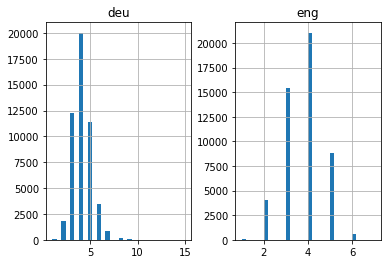

In [9]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [10]:
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [11]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6295


In [12]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10401


In [13]:
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [14]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [15]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [16]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [17]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [18]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 9s 293us/step - loss: 3.4309 - val_loss: 2.9098

Epoch 00001: val_loss improved from inf to 2.90978, saving model to model.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 7s 222us/step - loss: 2.7888 - val_loss: 2.7457

Epoch 00002: val_loss improved from 2.90978 to 2.74568, saving model to model.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 7s 222us/step - loss: 2.6068 - val_loss: 2.5958

Epoch 00003: val_loss improved from 2.74568 to 2.59583, saving model to model.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 7s 221us/step - loss: 2.4505 - val_loss: 2.4851

Epoch 00004: val_loss improved from 2.59583 to 2.48508, saving model to model.h1.24_jan_19
Epoch 5/30
32000/32000 [==============================] - 7s 222us/step - loss: 2.3065 - val_loss: 2.3808

Epoch 00005: val_loss improved from 2.48508 to 2.38084, 

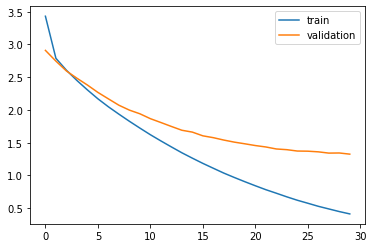

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [20]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [21]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [22]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [23]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [24]:
pred_df.sample(15)

,actual,predicted
704,i can probably win,i can win
8556,empty your bags,open your bags
1501,how is your brother,hows your brother
3347,tomll know,tom will know
4774,tom texted mary,tom winked mary
5696,tom became mute,tom went mute
3909,our cat is missing,our cat is gone
6005,i miss it,i me
237,tom seldom gets sick,tom will be late
9469,tom isnt afraid,tom doesnt eating


In [ ]:
model.predict()